In [ ]:
# Created By : Jhanvi Zala
# Date : April 07 2023

## **Install & Import Libraries**

In [5]:
!pip install numpy
!pip install torch torchvision   #(must be greater than 1.7, I used torch 1.10+cu11)
!pip install scikit-build
!pip install matplotlib
!pip install split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 3.4 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print(device)

cuda:0


## **Resize & Normalize Image**

In [7]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## **Load & Split Dataset**

In [8]:
dataset_dir = '/kaggle/input/caltect256/Caltech256'

In [9]:
import splitfolders

splitfolders.fixed(dataset_dir, output="output",
    seed=1337, fixed=(50, 10), oversample=False,group_prefix=None, move=False)


Copying files: 30608 files [03:41, 137.91 files/s]


In [10]:
train_dir = "/kaggle/working/output/train"
test_dir = "/kaggle/working/output/test"

train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=1)


In [11]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 15187
Test dataset size: 2570
Class names: ['001.ak47', '002.american-flag', '003.backpack', '004.baseball-bat', '005.baseball-glove', '006.basketball-hoop', '007.bat', '008.bathtub', '009.bear', '010.beer-mug', '011.billiards', '012.binoculars', '013.birdbath', '014.blimp', '015.bonsai-101', '016.boom-box', '017.bowling-ball', '018.bowling-pin', '019.boxing-glove', '020.brain-101', '021.breadmaker', '022.buddha-101', '023.bulldozer', '024.butterfly', '025.cactus', '026.cake', '027.calculator', '028.camel', '029.cannon', '030.canoe', '031.car-tire', '032.cartman', '033.cd', '034.centipede', '035.cereal-box', '036.chandelier-101', '037.chess-board', '038.chimp', '039.chopsticks', '040.cockroach', '041.coffee-mug', '042.coffin', '043.coin', '044.comet', '045.computer-keyboard', '046.computer-monitor', '047.computer-mouse', '048.conch', '049.cormorant', '050.covered-wagon', '051.cowboy-hat', '052.crab-101', '053.desk-globe', '054.diamond-ring', '055.dice', '056.dog', '

## **Visualize the Images**

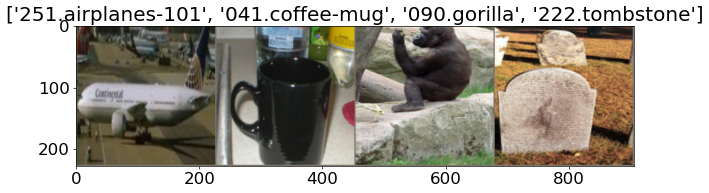

In [12]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

## **Define CNN Model & Train** 

In [33]:
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=8, out_channels=16, stride=1,kernel_size=3,padding=1)
        self.relu3 = nn.ReLU()
        self.conv_layer4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3,stride=1,padding=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.relu4 = nn.ReLU()
        self.max_pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride=1,padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.linear1 = nn.Linear(1568, 500)
        self.relu6 = nn.ReLU()
        self.linear2 = nn.Linear(500, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)
        
        out = self.conv_layer3(out)
        out = self.relu3(out)
        out = self.max_pool3(out)
        
        out = self.conv_layer4(out)
        out = self.relu4(out)
        out = self.max_pool4(out)
        
        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)
        
                
        out = out.reshape(out.size(0), -1)
        
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.softmax(out)
        return out

In [34]:
# !pip install torch-summary
from torchsummary import summary

# model = models.resnet18(pretrained=True)   #load resnet18 model
# num_features = model.fc.in_features     #extract fc layers features
# model.fc = nn.Linear(num_features, 257) #(num_of_class == 2)
model = ConvNeuralNet(257)
print(model)
summary(model,(3,224,224))
model = model.to(device)

criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv_layer4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu4): ReLU()
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (max_pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=156

## **Train The Model**

In [35]:
num_epochs = 20   #(set no of epochs)
start_time = time.time() #(for showing time)
loss_list = []
acc_list = []
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc)
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

Epoch 0 running
[Train #0] Loss: 5.2484 Acc: 5.0504% Time: 107.5334s
Epoch 1 running
[Train #1] Loss: 5.0718 Acc: 7.7435% Time: 214.7309s
Epoch 2 running
[Train #2] Loss: 4.9202 Acc: 10.5617% Time: 322.6859s
Epoch 3 running
[Train #3] Loss: 4.8094 Acc: 11.8193% Time: 430.8298s
Epoch 4 running
[Train #4] Loss: 4.7009 Acc: 12.8531% Time: 538.3459s
Epoch 5 running
[Train #5] Loss: 4.5715 Acc: 14.6441% Time: 646.8147s
Epoch 6 running
[Train #6] Loss: 4.4435 Acc: 16.1190% Time: 754.1384s
Epoch 7 running
[Train #7] Loss: 4.3530 Acc: 16.9290% Time: 861.1678s
Epoch 8 running
[Train #8] Loss: 4.2484 Acc: 17.8508% Time: 968.3523s
Epoch 9 running
[Train #9] Loss: 4.1595 Acc: 19.2270% Time: 1074.2129s
Epoch 10 running
[Train #10] Loss: 4.0710 Acc: 20.0764% Time: 1180.0659s
Epoch 11 running
[Train #11] Loss: 4.0046 Acc: 21.2221% Time: 1286.2052s
Epoch 12 running
[Train #12] Loss: 3.9054 Acc: 22.3876% Time: 1391.8610s
Epoch 13 running
[Train #13] Loss: 3.8436 Acc: 23.0329% Time: 1498.5860s
Epoch 14 

In [36]:
""" Testing Phase """
model.eval()
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

[Test #19] Loss: 4.4945 Acc: 14.5525% Time: 2192.0066s


In [37]:
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

## **Save the Model** 

In [38]:
save_path = 'caltec_cnn_pytorch.pth'
torch.save(model.state_dict(), save_path)

## **Load Save Model and Evaluate**

In [39]:
model = ConvNeuralNet(257)   #load resnet18 model
# num_features = model.fc.in_features #extract fc layers features
# model.fc = nn.Linear(num_features, 257)#(num_of_class == 2)
model.load_state_dict(torch.load("caltec_cnn_pytorch.pth"))
model.to(device)

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv_layer4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu4): ReLU()
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (max_pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=156

======>RESULTS<======


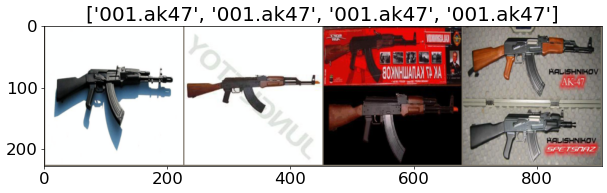

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
##Testing
model.eval()
start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if i == 0:
            print('======>RESULTS<======')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
          format(epoch, epoch_loss, epoch_acc, time.time() - start_time))